In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [13]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Validation set
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
def build_vgg19(dropout_rate=0.5, l2_reg=0.0):
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg), input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [ ]:
model = build_vgg19()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
initial_history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))
initial_weights = model.get_weights()

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 537s 852ms/step - accuracy: 0.1574 - loss: 2.1091 - val_accuracy: 0.2837 - val_loss: 1.7960
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 528s 845ms/step - accuracy: 0.3390 - loss: 1.6739 - val_accuracy: 0.4977 - val_loss: 1.3776
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 528s 844ms/step - accuracy: 0.5049 - loss: 1.3359 - val_accuracy: 0.5706 - val_loss: 1.1788
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 528s 845ms/step - accuracy: 0.6161 - loss: 1.0717 - val_accuracy: 0.6564 - val_loss: 0.9700
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 527s 843ms/step - accuracy: 0.6875 - loss: 0.8795 - val_accuracy: 0.6927 - val_loss: 0.8796
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 530s 849ms/step - accuracy: 0.7369 - loss: 0.7395 - val_accuracy: 0.6922 - val_loss: 0.9154
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 559s 894ms/step - accuracy: 0.7874 - loss: 0.6052 - val_accuracy: 0.7204 - val_loss: 0.8120
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 534s 855ms/step - accuracy: 0.8227 -

In [ ]:
learning_rates = [1e-4, 1e-5]
optimizers = [Adam, SGD, RMSprop]
dropout_rates = [0.3, 0.5]
l2_regularizations = [1e-4, 1e-5]

best_val_accuracy = 0
best_model = None
best_params = {}

for lr in learning_rates:
    for opt in optimizers:
        for dropout in dropout_rates:
            for reg in l2_regularizations:
                print(f"Training with learning rate={lr}, optimizer={opt.__name__}, dropout={dropout}, regularization={reg}")
                
                model.set_weights(initial_weights)
                
                model = build_vgg19(dropout_rate=dropout, l2_reg=reg)
                optimizer = opt(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
                
                history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val), verbose=0)
                
                val_accuracy = max(history.history['val_accuracy'])
                print(f"Validation Accuracy: {val_accuracy}")
                
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model = model
                    best_params = {'learning_rate': lr, 'optimizer': opt.__name__, 'dropout_rate': dropout, 'l2_regularization': reg}

print(f"\nBest Validation Accuracy: {best_val_accuracy}")
print("Best Parameters:", best_params)

Training with learning rate=0.0001, optimizer=Adam, dropout=0.3, regularization=0.0001
Validation Accuracy: 0.09520000219345093
Training with learning rate=0.0001, optimizer=Adam, dropout=0.3, regularization=1e-05
Validation Accuracy: 0.6536999940872192
Training with learning rate=0.0001, optimizer=Adam, dropout=0.5, regularization=0.0001
Validation Accuracy: 0.6326000094413757
Training with learning rate=0.0001, optimizer=Adam, dropout=0.5, regularization=1e-05
Validation Accuracy: 0.6697999835014343
Training with learning rate=0.0001, optimizer=SGD, dropout=0.3, regularization=0.0001
Validation Accuracy: 0.120899997651577
Training with learning rate=0.0001, optimizer=SGD, dropout=0.3, regularization=1e-05
Validation Accuracy: 0.09520000219345093
Training with learning rate=0.0001, optimizer=SGD, dropout=0.5, regularization=0.0001
Validation Accuracy: 0.15279999375343323
Training with learning rate=0.0001, optimizer=SGD, dropout=0.5, regularization=1e-05
Validation Accuracy: 0.1103999

In [ ]:
best_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
best_history = best_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 579s 910ms/step - accuracy: 0.9455 - loss: 0.1967 - val_accuracy: 0.7603 - val_loss: 1.0359
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 563s 900ms/step - accuracy: 0.9568 - loss: 0.1589 - val_accuracy: 0.7674 - val_loss: 1.0184
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 563s 900ms/step - accuracy: 0.9639 - loss: 0.1365 - val_accuracy: 0.7618 - val_loss: 1.0814
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 562s 899ms/step - accuracy: 0.9703 - loss: 0.1232 - val_accuracy: 0.7656 - val_loss: 1.1310
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 562s 900ms/step - accuracy: 0.9745 - loss: 0.1049 - val_accuracy: 0.7565 - val_loss: 1.2344
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 562s 899ms/step - accuracy: 0.9716 - loss: 0.1129 - val_accuracy: 0.7648 - val_loss: 1.2545
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 562s 899ms/step - accuracy: 0.9784 - loss: 0.0962 - val_accuracy: 0.7670 - val_loss: 1.1658
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 567s 908ms/step - accuracy: 0.9832 -

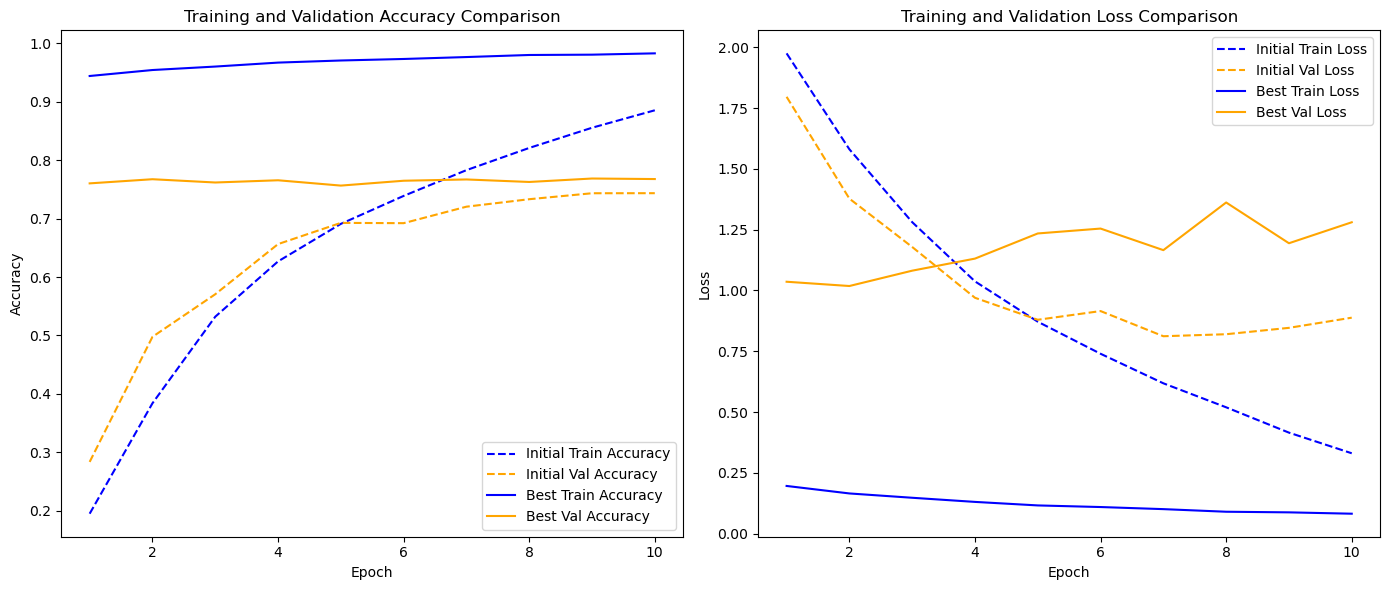

In [ ]:
initial_train_accuracy = initial_history.history['accuracy']
initial_val_accuracy = initial_history.history['val_accuracy']
initial_train_loss = initial_history.history['loss']
initial_val_loss = initial_history.history['val_loss']

#best_train_accuracy = best_model.history.history['accuracy']
#best_val_accuracy = best_model.history.history['val_accuracy']
#best_train_loss = best_model.history.history['loss']
#best_val_loss = best_model.history.history['val_loss']

best_train_accuracy = best_history.history['accuracy']
best_val_accuracy = best_history.history['val_accuracy']
best_train_loss = best_history.history['loss']
best_val_loss = best_history.history['val_loss']

epochs_initial = range(1, len(initial_train_accuracy) + 1)
epochs_best = range(1, len(best_train_accuracy) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_initial, initial_train_accuracy, label='Initial Train Accuracy', linestyle='--', color='blue')
plt.plot(epochs_initial, initial_val_accuracy, label='Initial Val Accuracy', linestyle='--', color='orange')
plt.plot(epochs_best, best_train_accuracy, label='Best Train Accuracy', linestyle='-', color='blue')
plt.plot(epochs_best, best_val_accuracy, label='Best Val Accuracy', linestyle='-', color='orange')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_initial, initial_train_loss, label='Initial Train Loss', linestyle='--', color='blue')
plt.plot(epochs_initial, initial_val_loss, label='Initial Val Loss', linestyle='--', color='orange')
plt.plot(epochs_best, best_train_loss, label='Best Train Loss', linestyle='-', color='blue')
plt.plot(epochs_best, best_val_loss, label='Best Val Loss', linestyle='-', color='orange')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()